# Guide to EFT samples for VVV analysis

Jonas Rembser, 2020-06-04

The 1 million inclusice WWW and 1 million di-lepton filtered WWZ events are ready in the UCSD environment, in **MiniAOD** and **NanoAODv7** formats:

```
/hadoop/cms/store/user/rembserj/samples/WWW_dim8_20200605_inclusive_RunIIAutumn18/
/hadoop/cms/store/user/rembserj/samples/WWZ_dim8_20200605_double_lepton_RunIIAutumn18/
```

The LHE files are also there, if you quickly want to check the LHE header.

You can find more information on how they were generated here:
https://github.com/guitargeek/vvv-eft-sample-production

This presentation explains all differences with respect to the normal NanoAOD samples that are relevant for analysis.

Even if this code here is in python, these aspects are also relevant if the analysis is done in C++.

### Loading sample

You need access to the event tree and an integral cross section (as well as luminosity). I take the cross section from the VVV analysis note here.

In [14]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# xsec = 216. # fb for WWW
xsec = 165.1 # fb for WWZ
lumi = 137. # fb^-1

In [16]:
events = uproot.open("../wwz/nano/file-001.root")["Events"]

### Branches that are different from central production

There are three branches (and their associated n-branches) which did not filled in the production, even though they should:

```
LHEPdfWeight
LHEReweightingWeight
LHEScaleWeight
```
The reweighting weight is of course very important for us, so it should not miss.

The problem is a differently formated LHE header with a newer madgraph version (a problem discussed in the hypernews). Since the responsible event data producer also produces other branches, I din't want to risk changing it. Instead, a new producer dumps the same weights under different names:

```
LHEWeight_PDF4LHC15_nnlo_30_pdfas
LHEWeight_mg_reweighting
LHEWeight_Central_scale_variation
```
In addition, there is `LHEWeight_NNPDF31_nnlo_hessian_pdfas` as an alternative set of PDF weights, which is preffered if `LHEWeight_PDF4LHC15_nnlo_30_pdfas` is missing. We have both now.

### Getting information on the reweighting

The branch with the reweighting weights is a column of vectors:

In [17]:
events.array("LHEWeight_mg_reweighting")

<JaggedArray [[0.0005953098 4.019456 1.0070806 ... 0.040005047 1.0 4.005295] [0.99833417 0.9996206 0.9982077 ... 0.9985442 1.0 1.0032052] [0.9836525 0.9647092 0.9718889 ... 0.9865552 1.0 1.0209315] ... [0.00035074688 4.0727124 1.0245882 ... 0.038369663 1.0 4.0235357] [0.0005632601 3.960794 0.9874946 ... 0.041541163 1.0 3.9858048] [3.2048057e-08 3.9998012 0.9999338 ... 0.04000533 1.0 3.9999337]] at 0x7f67b5467100>

It has the exact same number of entries per event, each corresponding to a reweighting point. The values of the operators at the different points are encoded in the branch name:

In [18]:
events["LHEWeight_mg_reweighting"].title

b'mg_reweighting (w_var / w_nominal);id,text;EFT_SM,set param_card anoinputs 12 0.0 # orig: 5e-12\n;EFT_FT0_m10,set param_card anoinputs 12 -1e-11 # orig: 5e-12\n;EFT_FT0_m5,set param_card anoinputs 12 -5e-12 # orig: 5e-12\n;EFT_FT0_m1,set param_card anoinputs 12 -1e-12 # orig: 5e-12\n;EFT_FT0_1,set param_card anoinputs 12 1e-12 # orig: 5e-12\n;EFT_FT0_5,;EFT_FT0_10,set param_card anoinputs 12 1e-11 # orig: 5e-12\n'

To make it a bit more human-readable:

In [19]:
def get_df_mg_reweighting_info(events):
    import io
    csv_str = events["LHEWeight_mg_reweighting"].title.decode("utf-8")
    return pd.read_csv(io.StringIO(csv_str), lineterminator=';', skiprows=1)

In [20]:
get_df_mg_reweighting_info(events)

,id,text
0,EFT_SM,set param_card anoinputs 12 0.0 # orig: 5e-12\n
1,EFT_FT0_m10,set param_card anoinputs 12 -1e-11 # orig: 5e-...
2,EFT_FT0_m5,set param_card anoinputs 12 -5e-12 # orig: 5e-...
3,EFT_FT0_m1,set param_card anoinputs 12 -1e-12 # orig: 5e-...
4,EFT_FT0_1,set param_card anoinputs 12 1e-12 # orig: 5e-12\n
5,EFT_FT0_5,NaN
6,EFT_FT0_10,set param_card anoinputs 12 1e-11 # orig: 5e-12\n


You see that there are no commands for `EFT_FT0_5`, because $\text{F}_\text{T0} = 5~\text{TeV}^{-4}$ it is the central value in the generation.

### Using the reweighting

For better compression, NanoAOD saves the relative reweighting weights, so to get the actual weights one needs to multiply them with the `genWeight` of the event.

You also need to be careful with the normalization: since the `genWeight` is computed for the central values of the EFT operators, which is not the standard model, the normalization has to be the sum of the gen-weights multiplied with the SM weights per event.

This is how it could be done in python, further multiplying the normalized weights with the luminosity times cross section reference value:

In [21]:
def get_df_mg_reweighting(events, standard_model=None):
    gen_weight = events.array("genWeight")
    
    df_info = get_df_mg_reweighting_info(events)
    mg_reweighting = gen_weight * events.array("LHEWeight_mg_reweighting")
    df = pd.DataFrame(mg_reweighting.flatten().reshape((len(mg_reweighting), len(mg_reweighting[0]))))
    df.columns = df_info["id"].values
    
    if standard_model is None:
        norm = np.sum(gen_weight)
    else:
        norm = df[standard_model].sum()
    
    return df * xsec * lumi / norm

In [22]:
df_weights = get_df_mg_reweighting(events, standard_model="EFT_SM")

In [23]:
df_weights.head()

,EFT_SM,EFT_FT0_m10,EFT_FT0_m5,EFT_FT0_m1,EFT_FT0_1,EFT_FT0_5,EFT_FT0_10
0,0.000229,1.546990,0.387601,0.015942,0.015397,0.384876,1.541540
1,0.388116,0.388616,0.388066,0.388058,0.388197,0.388763,0.390009
2,0.378584,0.371293,0.374056,0.377537,0.379701,0.384876,0.392932
3,0.015851,1.394285,0.352320,0.026705,0.033216,0.384876,1.459395
4,0.385776,0.380285,0.382950,0.385198,0.386360,0.388763,0.391912


### Validating parabolic shape of weights

A quick check if the weights are really parabolic:

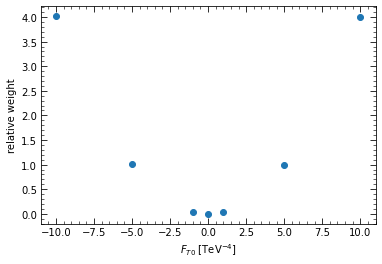

In [24]:
w = events.array("LHEWeight_mg_reweighting")[80]
plt.scatter([0, -10, -5, -1, 1, 5, 10], w)
plt.ylabel("relative weight")
plt.xlabel("$F_{T0}$ $[$TeV$^{-4}]$")
plt.show()

### Validate enhancement in tail of $s_T$ distribution

This example plots a simple $s_T$ distribution without any event selection, just as a samity check.

In [25]:
def get_st_variable(events):
    return events.array("Electron_pt").sum() + \
           events.array("Jet_pt").sum() + \
           events.array("MET_pt")

In [26]:
df = pd.DataFrame(dict(sT=get_st_variable(events)))

In [27]:
def to_string(x):
    return str(x).replace("-", "m").replace(".", "p")

def to_number(label):
    return int(label.replace("m", "-").replace("p", "."))

In [28]:
def decode_parameters(label, strip_zero_parameters=True):
    """Decode a label back to a divionary of operator values.
    """
    l = label.split("_")[1:]
    if l == ['SM']:
        return {}
    
    l = [a + "_" + b for a, b in zip(l[::2], l[1::2])]

    parameters = {k.upper() : to_number(v) for k, v in map(lambda x: x.split("_"), l)}
    
    if strip_zero_parameters:
        return {name : x for name, x in parameters.items() if x != 0}
    
    return parameters

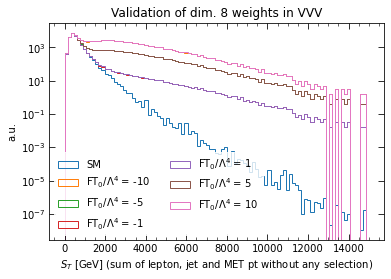

In [29]:
bins = np.linspace(0, 15000, 100)
for weight_label in df_weights.columns:
    parameters = decode_parameters(weight_label)
    label = f"FT$_0$/$\Lambda^4$ = {list(parameters.values())[0]}" if len(parameters) > 0 else "SM"
    plt.hist(df["sT"], bins=bins, weights=df_weights[weight_label], histtype="step", label=label)
plt.legend(loc="lower left", ncol=2)
plt.gca().set_yscale('log')
plt.ylabel("a.u.")
plt.title("Validation of dim. 8 weights in VVV")
plt.xlabel(r"$S_T$ [GeV] (sum of lepton, jet and MET pt without any selection)")
plt.show()

### Validating double-lepton filter

In [30]:
import geeksw.analysis.genpart as genpart

In [33]:
def count_leptons_from_weak_boson_decays(events):
    df = events.pandas.df([b"GenPart_genPartIdxMother", b"GenPart_pdgId"], flatten=True)
    df["GenPart_pdgIdMother"] = genpart.get_pdgIdMother(df)

    df = df.query("abs(GenPart_pdgIdMother) == 24 or GenPart_pdgIdMother == 23")
    df = df.reset_index()
    
    # The group-by operation is just a quick and dirty way to do it in this validation.
    # Of course it's very inefficient because it doesn't assume that the rows are already grouped by event.
    # That's why we just look at 1000 events, which is 1 % of the file.
    df_counts = df.query("entry < 1000").groupby("entry")["GenPart_pdgId"].agg(
        n_ele=lambda x: np.sum(np.abs(x) == 11),
        n_mu=lambda x: np.sum(np.abs(x) == 13),
        n_tau=lambda x: np.sum(np.abs(x) == 15),
    )

    return df_counts

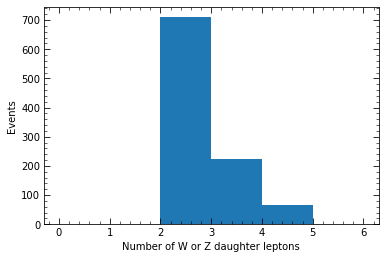

In [35]:
df_counts = count_leptons_from_weak_boson_decays(events)
plt.hist(df_counts.sum(axis=1), bins=np.linspace(0, 6, 7))
plt.xlabel("Number of W or Z daughter leptons")
plt.ylabel("Events")
plt.show()